# Automated Region Seeding Using Visibility  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
# import visualizations_utils as viz_utils
# from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [3]:
#pydrake imports
import pydrake
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint, Role

import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.multibody.tree import JacobianWrtVariable
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (IrisOptions, 
                                           IrisInConfigurationSpace,
                                           #IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from pydrake.common import FindResourceOrThrow
#from pydrake.all import ConnectMeshcatVisualizer
from pydrake.all import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat,InverseKinematics, RotationMatrix
#from meshcat import Visualizer
#from visprm import VPRMSeeding, RandSeeding
from dijkstraspp import DijkstraSPPsolver
from pydrake.all import Rgba, Sphere
import os

<ipython-input-3-31d871d84fda>:9: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  from pydrake.solvers import mathematicalprogram as mp


In [4]:
meshcat1 = StartMeshcat()
meshcat1.Delete()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [5]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
parser = Parser(plant)
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat1)
directives_file = "../../drake/C_Iris_Examples/7_dof_directives.yaml"#FindResourceOrThrow() 
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)
Ratfk = RationalForwardKinematics(plant)

<ipython-input-5-d6231ea7a536>:12: DrakeDeprecationWarning: (Deprecated) See ForcedPublish() 
*/ (Deprecated.)

Deprecated:
    Use ForcedPublish() instead This will be removed from Drake on or
    after 2023-03-01.
  diagram.Publish(context)


In [45]:
sliders = []
for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

q_low = [plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit() for joint_idx in range(1,8)]
q_high= [plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit() for joint_idx in range(1,8)]

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5)    

def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    col = col_func_handle(q)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat1.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat1.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat1.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    diagram.ForcedPublish(context)
    #print("              ", end = "\r")
    #print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

In [7]:
from fractions import Fraction
import itertools
import colorsys
import random
def infinite_hues():
    yield Fraction(0)
    for k in itertools.count():
        i = 2**k # zenos_dichotomy
        for j in range(1,i,2):
            yield Fraction(j,i)

def hue_to_hsvs(h: Fraction):
    # tweak values to adjust scheme
    for s in [Fraction(6,10)]:
        for v in [Fraction(6,10), Fraction(9,10)]:
            yield (h, s, v)

def rgb_to_css(rgb) -> str:
    uint8tuple = map(lambda y: int(y*255), rgb)
    return tuple(uint8tuple)

def n_colors(n=33, rgbs_ret = False):
    hues = infinite_hues()
    hsvs = itertools.chain.from_iterable(hue_to_hsvs(hue) for hue in hues)
    rgbs = (colorsys.hsv_to_rgb(*hsv) for hsv in hsvs)
    csss = (rgb_to_css(rgb) for rgb in rgbs)
    to_ret = list(itertools.islice(csss, n)) if rgbs_ret else list(itertools.islice(csss, n))
    return to_ret

def n_colors_random(n=33, rgbs_ret = True):
    colors = n_colors(100 * n, rgbs_ret)
    return random.sample(colors, n)

def plot_points(points, 
                size = 0.02, 
                color = Rgba(0.06, 0.0, 0, 1), 
                start_idx = 0, 
                prefix = 'point'):
       
        
        for i in range(points.shape[0]):
            pt = points[i]
            set_joint_angles(pt)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            
            meshcat1.SetObject(f"/iris/points/{prefix}/{i+start_idx}",
                                   Sphere(size),
                                   color)
            
            meshcat1.SetTransform(f"/iris/points/{prefix}/{i+start_idx}",
                                       RigidTransform(RotationMatrix(),
                                                      tf))

In [8]:

for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_6', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_7', max=3.05433, min=-3.05433)

In [9]:
# import time
# for idx in range(100):
#     q = vs.sample_node_pos(outside_regions=True)
#     showres(q)
#     time.sleep(0.01)

In [10]:
#from pydrake.all import Box, GetVertices
query = scene_graph.get_query_output_port().Eval(scene_graph.GetMyContextFromRoot(context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(geomids))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in frame_id_dict.keys()]

sh_frames = [9,10,11]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['box', 'l','r']
def plot_endeff_pose(q, name = '', color = Rgba(1,1,0.1,0.8)):
    set_joint_angles(q)
    tfs = [plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(f))) for f in sh_frames]
    for n, f, geom in zip(sh_names, tfs, sh_geom):
        meshcat1.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        meshcat1.SetTransform("/iris/shunk/"+name+"/"+n, f)

{'body': <GeometryId value=73>, 'left_finger': <GeometryId value=79>, 'right_finger': <GeometryId value=85>}


In [11]:
#problem config
 
start = np.array([1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0])
target = np.array([-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567])

poi = np.array([[1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0],
                [-1.96706,  1.3056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
                [-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567],
         [-1.26706,  0.9056 ,  0.13294, -1.0944 , -1.66706, -1.1944 ,
        0.04567],
         [-1.26706,  1.3056 ,  0.13294, -1.0944 , -1.46706, -1.1944 ,
        0.04567],
         [-1.26706,  1.2056 , -0.16706,  0.1056 , -1.46706, -1.1944 ,
        0.04567],
         [ 1.13294,  0.8056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
        [ 1.03294,  0.1056 , -0.06706, -1.5944 , -1.46706,  1.0056 ,
       -1.55433],
        [-1.76706,  0.9056 , -0.26706, -1.0944 , -1.36706,  1.1056 ,
        1.94567],
        [ 2.03294,  0.9056 , -0.26706, -1.0944 , -1.16706, -1.2944 ,
        -0.45433],
        [ 2.23294,  0.6056 , -0.26706, -1.0944 , -1.46706, -1.2944 ,
        -0.05433],
        [ 1.83294,  1.9056 , -0.16706,  0.2056 , -1.36706, -1.2944 ,
        2.71],])
       
def pull_back_point(pt):
    set_joint_angles(pt)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    shunk_frame = shunk.body_frame()
    world_frame = plant.world_frame() 
    J = plant.CalcJacobianSpatialVelocity(plant_context, 
                                          JacobianWrtVariable.kQDot,
                                            shunk_frame,
                                            [0,0,0],
                                            world_frame,
                                         world_frame)


    #shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()

    # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    v_pullback = -tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    pos_pullback = tf + v_pullback
    pt_new = pt + np.linalg.pinv(J[3:,:])@v_pullback
    return pt_new

helpers = []
for p in poi:
    ph = pull_back_point(p)
    helpers.append(ph)
helpers = np.array(helpers)
        
for i, p in enumerate(poi[:12]):
    plot_endeff_pose(p, str(i))
    
poi = np.concatenate((poi, helpers), axis = 0)

showres(target)
limits_q =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]
crit_idx = [-1, 0, 2, 4]
for idx in crit_idx:
    limits_q[0][idx] *=0.90
    limits_q[1][idx] *=0.90

limits_t = [Ratfk.ComputeSValue(l, np.zeros(len(l))) for l in limits_q]
domain = HPolyhedron.MakeBox(limits_t[0], limits_t[1])
#poi = [start, target]
plot_points(np.array(poi))
plot_points(np.array(poi[12:]), color = Rgba(0, 1, 0, 1.0), prefix='helper')
for p in poi:
    if not domain.PointInSet(Ratfk.ComputeSValue(p, np.zeros(7))):
        print(domain.PointInSet(Ratfk.ComputeSValue(p, np.zeros(7))))

In [12]:
pt = poi[4]
showres(pt)
q = pt

In [13]:
from visibility_utils import point_in_regions
from tqdm import tqdm
from scipy.sparse import lil_matrix

In [14]:
p = np.array([q, q])
showres(poi[2])

In [15]:
#setup visibility seeding helpers
scaler = np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) #do you even geometry bro?
q_min = np.array(q_low)*scaler
q_max = np.array(q_high)*scaler
q_diff = q_max-q_min

q_star = np.zeros(7)

alpha = 0.05
eps = 0.2
N = 1000
seed = 1
np.random.seed(seed)

def estimate_coverage(regions, pts = 3000):
	pts_ = [sample_cfree_QPoint() for _ in range(pts)]
	inreg = 0
	for pt in pts_:
		if point_in_regions(pt, regions): inreg+=1
	return inreg/pts

def sample_cfree_QPoint(MAXIT=1000):
	it = 0
	while it<MAXIT:
		rand = np.random.rand(7)
		q_s = q_min + rand*q_diff
		col = False
		for _ in range(10):
			r  = 0.1*(np.random.rand(7)-0.5)
			col |= (col_func_handle(q_s+r) > 0)
		if not col:
			return q_s #Ratfk.ComputeQValue(q_s, q_star)
		it+=1
	raise ValueError("no col free point found")

def sample_cfree_QPoint_in_regions(regions):
	for _ in range(1000):
		pt = sample_cfree_QPoint()
		if point_in_regions(pt, regions): return Ratfk.ComputeQValue(pt, q_star)
	return None

def sample_cfree_handle(n, m, regions=None):
		points = np.zeros((n,7))
		if regions is None: regions = []		
		for i in range(n):
			bt_tries = 0
			while bt_tries<m:
				point = sample_cfree_QPoint()
				col = False
				for _ in range(10):
					r  = 0.05*(np.random.rand(7)-0.5)
					col |= point_in_regions(point+r, regions)
				if col:
					bt_tries += 1
					if bt_tries == m:
						return points, True 
				else:
					break
			points[i] = point
		return points, False

def visSSpace(t1, t2, regions, num_checks, visualizer):
	t1flat = t1.reshape(-1)
	t2flat = t2.reshape(-1)
	if np.linalg.norm(t1-t2) < 1e-6:
		return (1-col_func_handle(Ratfk.ComputeQValue(t1flat, q_star)))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		tinterp = t1flat*t + (1-t)*t2flat
		if col_func_handle(Ratfk.ComputeQValue(tinterp, q_star)):
			return False
		elif point_in_regions(tinterp, regions):
			return False
	else:
		return True

def vis(q1, q2, regions, num_checks):
	q1flat = q1.reshape(-1)
	q2flat = q2.reshape(-1)
	if np.linalg.norm(q1-q2) < 1e-6:
		return (1-col_func_handle(q1))>0
				
	tvec = np.linspace(0,1, num_checks)
	for t in tvec:
		qinterp = q1flat*t + (1-t)*q2flat
		if col_func_handle(qinterp):
			return False
		elif point_in_regions(qinterp, regions):
			return False
	else:
		return True
    
visibility_checker = partial(vis, num_checks = 40)

def vgraph_builder(points, regions):
	n = len(points)
	adj_mat = lil_matrix((n,n))
	for i in tqdm(range(n)):
		point = points[i, :]
		for j in range(len(points[:i])):
			other = points[j]
			result = visibility_checker(point, other, regions)
			#print(result)
			if result:
				adj_mat[i,j] = adj_mat[j,i] = 1
	return adj_mat.toarray()
#from pydrake.all import ComputeVisibilityGraph
#vgraph_builder2 = partial(ComputeVisibilityGraph, plant = plant, plant_context = plant_context, num_samples = 30, tolerance = 0.001)

# Setup SNOPT IRIS

In [16]:
from pydrake.all import MosekSolver, SolverOptions, CommonSolverOption
# The object we will use to perform our certification.
from pydrake.geometry.optimization_dev import (CspaceFreePolytope,
                                               CIrisSeparatingPlane,
                                               SeparatingPlaneOrder)
from pydrake.geometry.optimization import ComputeVisibilityGraph

In [17]:
# cspace_free_polytope = CspaceFreePolytope(plant, scene_graph,
#                                           SeparatingPlaneOrder.kAffine, q_star)
# solver_id = MosekSolver.id()

# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# # The options for when we search for new planes and positivity certificates given the polytopes
# find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
# find_separation_certificate_given_polytope_options.num_threads = -1
# find_separation_certificate_given_polytope_options.verbose = False
# find_separation_certificate_given_polytope_options.solver_options = solver_options
# find_separation_certificate_given_polytope_options.ignore_redundant_C = False
# find_separation_certificate_given_polytope_options.solver_id = solver_id

# # The options for when we search for a new polytope given positivity certificates.
# find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
# find_polytope_given_lagrangian_option.solver_options = solver_options
# find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
# find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
# find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-4
# find_polytope_given_lagrangian_option.solver_id = solver_id

# # bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
# # bilinear_alternation_options.max_iter = 10
# # bilinear_alternation_options.convergence_tol = 1e-3
# # bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
# # bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

# binary_search_options = CspaceFreePolytope.BinarySearchOptions()
# binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
# binary_search_options.scale_min = 1e-3
# binary_search_options.scale_max = 1.1
# binary_search_options.max_iter = 6

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 10
snopt_iris_options.configuration_space_margin = 1e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 1
snopt_iris_options.relative_termination_threshold = 0.02

In [18]:
def SNOPT_IRIS(q_seeds,  region_obstacles, logger, plant, context, snoptiris_options):
	regions = []
	for reg_indx, q_seed in enumerate(q_seeds):
		#q_seed = Ratforwardkin.ComputeQValue(s_seed.reshape(-1,1), np.zeros((7,1)))
		#print('snopt iris call')
		snoptiris_options.configuration_obstacles = []
		if len(region_obstacles):
			snoptiris_options.configuration_obstacles = region_obstacles
		plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
		try:
			#r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), q_star, snoptiris_options)
			r = IrisInConfigurationSpace(plant, plant_context, snoptiris_options)
			print(f"[SNOPT IRIS]: Region:{reg_indx} / {len(q_seeds)}")
			#run the certifier
			# cert = cspace_free_polytope.BinarySearch(set(),
			# 								r.A(),
			# 								r.b(), 
			# 								np.array(s_seed),
			# 								binary_search_options)
			if logger is not None: logger.log_region(r)
			# r = cert.certified_polytope
			regions.append(r)
		except:
			print("error, SNOPT IRIS FAILED")
	return regions

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
			    			#binary_search_options = binary_search_options,
                            #Ratforwardkin = Ratfk,
                            )


In [71]:
import numpy as np

In [80]:
alpha = 0.1
eps = 0.1
N = 400
np.log(1-(alpha)**(1/N))/np.log(1-eps)

48.97763569497781

In [ ]:
from visibility_seeding import VisSeeder
from visibility_logging import Logger
LOAD_CHKPT = True
logger = Logger("7DOf_shelves", seed, N, alpha, eps, estimate_coverage)
VS = VisSeeder(N = N,
            alpha = alpha,
            eps = eps,
            max_iterations = 10,
            sample_cfree = sample_cfree_handle,
            build_vgraph = vgraph_builder,
            iris_w_obstacles = SNOPT_IRIS_Handle,
            verbose = True,
            logger = logger
            )
if not LOAD_CHKPT:
    out = VS.run()
else:
    exp_name = "7DOf_shelves_20230617114513_1_1000_0.050_0.200"
    poly_names = os.listdir("logs/"+exp_name+"/regions")

In [ ]:
r_poi = SNOPT_IRIS_Handle(poi, [], None) 

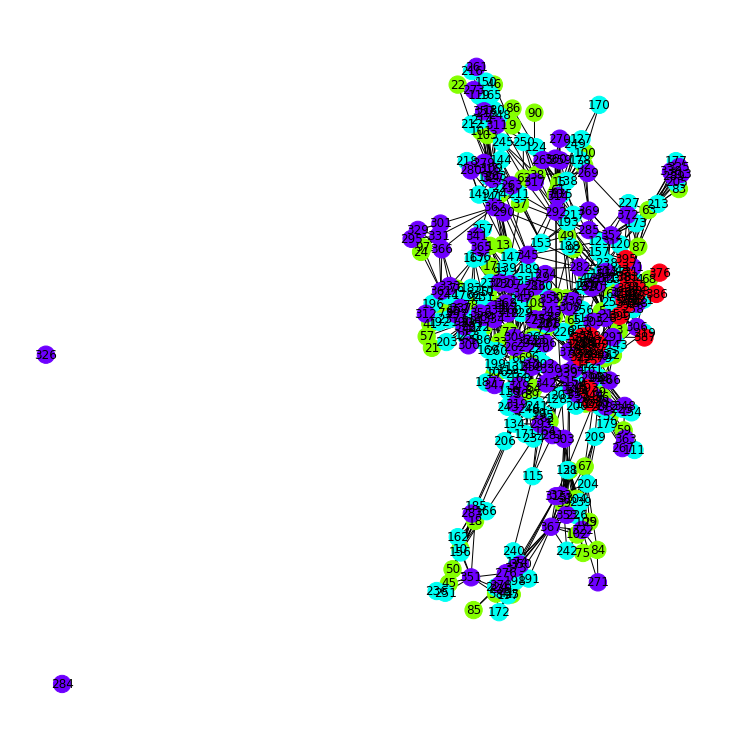

In [36]:
import pickle
import networkx as nx
from visibility_utils import generate_distinct_colors
import matplotlib.pyplot as plt

exp_name = "7DOf_shelves_20230617114513_1_1000_0.050_0.200"
poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
poly_names.sort()
data_chkpts.sort()
regions = []
for p in poly_names:
    with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
        d = pickle.load(f)
    regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+data_chkpts[-1], 'rb') as f:
    d = pickle.load(f)

region_groups_sizes = [len(g) for g in d['rb']]
len_reg = np.sum(region_groups_sizes) 
region_groups_sizes.append(len(regions)-len_reg)
region_groups = []
idx = 0
for s in region_groups_sizes:
    grp = []
    for i in range(s):
        grp.append(regions[i+idx])
    idx+=len(grp)
    region_groups.append(grp)

regions+=r_poi
region_groups.append(r_poi)
connectivity_graph = nx.Graph()
for idx in range(len(regions)):
    connectivity_graph.add_node(idx)
    
for idx1 in range(len(regions)):
    for idx2 in range(idx1 +1, len(regions)):
        r1 = regions[idx1]
        r2 = regions[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(len(region_groups)+1)[1:]
colors = []
for g, h in zip(region_groups, hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.show()

In [35]:
r_poi = SNOPT_IRIS_Handle(poi, [], None) 

[SNOPT IRIS]: Region:0 / 24
[SNOPT IRIS]: Region:1 / 24
[SNOPT IRIS]: Region:2 / 24
[SNOPT IRIS]: Region:3 / 24
[SNOPT IRIS]: Region:4 / 24
[SNOPT IRIS]: Region:5 / 24
[SNOPT IRIS]: Region:6 / 24
[SNOPT IRIS]: Region:7 / 24
[SNOPT IRIS]: Region:8 / 24
[SNOPT IRIS]: Region:9 / 24
[SNOPT IRIS]: Region:10 / 24
[SNOPT IRIS]: Region:11 / 24
[SNOPT IRIS]: Region:12 / 24
[SNOPT IRIS]: Region:13 / 24
[SNOPT IRIS]: Region:14 / 24
[SNOPT IRIS]: Region:15 / 24
[SNOPT IRIS]: Region:16 / 24
[SNOPT IRIS]: Region:17 / 24
[SNOPT IRIS]: Region:18 / 24
[SNOPT IRIS]: Region:19 / 24
[SNOPT IRIS]: Region:20 / 24
[SNOPT IRIS]: Region:21 / 24
[SNOPT IRIS]: Region:22 / 24
[SNOPT IRIS]: Region:23 / 24


In [42]:
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        set_joint_angles(qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

In [37]:
def conversion_dummy(q):
    return q

In [38]:
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)


[DijkstraSPP] Pre-Building adjacency matrix  0 / 400
[DijkstraSPP] Pre-Building adjacency matrix  10 / 400
[DijkstraSPP] Pre-Building adjacency matrix  20 / 400
[DijkstraSPP] Pre-Building adjacency matrix  30 / 400
[DijkstraSPP] Pre-Building adjacency matrix  40 / 400
[DijkstraSPP] Pre-Building adjacency matrix  50 / 400
[DijkstraSPP] Pre-Building adjacency matrix  60 / 400
[DijkstraSPP] Pre-Building adjacency matrix  70 / 400
[DijkstraSPP] Pre-Building adjacency matrix  80 / 400
[DijkstraSPP] Pre-Building adjacency matrix  90 / 400
[DijkstraSPP] Pre-Building adjacency matrix  100 / 400
[DijkstraSPP] Pre-Building adjacency matrix  110 / 400
[DijkstraSPP] Pre-Building adjacency matrix  120 / 400
[DijkstraSPP] Pre-Building adjacency matrix  130 / 400
[DijkstraSPP] Pre-Building adjacency matrix  140 / 400
[DijkstraSPP] Pre-Building adjacency matrix  150 / 400
[DijkstraSPP] Pre-Building adjacency matrix  160 / 400
[DijkstraSPP] Pre-Building adjacency matrix  170 / 400
[DijkstraSPP] Pre-Bui

In [58]:
import time

start = poi[0]
for _ in range(20):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(12)]
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            #if col_func_handle(qa):
            #print(col)
            #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        meshcat1.Delete("/iris/points/traj/")
        
    else:
        nxt = poi[np.random.choice(12)]

[DijkstraSPP] optimized distance/ start-distance = 6.89 / 8.57 = 0.80
6.8859969286497655
[DijkstraSPP] optimized distance/ start-distance = 10.74 / 14.87 = 0.72
10.738443701625705


KeyboardInterrupt: 

# CSPACE Projection

In [60]:
coords = [0,1,2]

q_low_vis = (np.array(q_low)[coords]).tolist()
q_high_vis = (np.array(q_high)[coords]).tolist()
#coordinates of q0 that are not in coords list are the ones we project onto 
q0 = np.array([ 0.09901949,  0.40832405, -1.34900509,  1.91800265, -1.1577164 ,
       -1.24136945,  1.15125847])

In [61]:
meshcat2 = StartMeshcat()
builder2 = DiagramBuilder()
plant2, scene_graph2 = AddMultibodyPlantSceneGraph(builder2, time_step=0.0)
vis2 = MeshcatVisualizer.AddToBuilder(builder2, scene_graph2, meshcat2)


INFO:drake:Meshcat listening for connections at http://localhost:7001


In [63]:
import old_vis_utils as viz_utils
import mcubes
from pydrake.all import  StartMeshcat, MeshcatVisualizer, DiagramBuilder, \
    AddMultibodyPlantSceneGraph, TriangleSurfaceMesh, Rgba, SurfaceTriangle, Sphere

def transfrom_regions(regions, q_proj, dof_coords):
    small_regs = []
    for r in regions:
        A_new = r.A()[:,dof_coords]
        c_dofs = []
        for i in range(7):
            if i not in dof_coords:
                c_dofs.append(i)
        A_const = r.A()[:, c_dofs]  
        b_new = r.b() - A_const@q_proj[c_dofs]
        #check if region is empty
        rn = HPolyhedron(A_new, b_new)
        if not rn.IsEmpty():
            small_regs.append(rn)
        else:
            print("projected region is empty")
    return small_regs

def plot_regions(regions, ellipses = None,
                     region_suffix = '', colors = None,
                     wireframe = False,
                     opacity = 0.7,
                     fill = True,
                     line_width = 10,
                     darken_factor = .2,
                     el_opacity = 0.3):
        if colors is None:
            colors = viz_utils.n_colors_random(len(regions), rgbs_ret=True)

        for i, region in enumerate(regions):
            c = Rgba(*[col/255 for col in colors[i]],opacity)
            prefix = f"/iris/regions{region_suffix}/{i}"
            name = prefix + "/hpoly"
            if region.ambient_dimension() == 3:
                plot_hpoly3d(name, region,
                                  c, wireframe = wireframe, resolution = 30)

def get_plot_poly_mesh(region, resolution):

        def inpolycheck(q0, q1, q2, A, b):
            q = np.array([q0, q1, q2])
            res = np.min(1.0 * (A @ q - b <= 0))
            # print(res)
            return res

        aabb_max, aabb_min = viz_utils.get_AABB_limits(region)

        col_hand = partial(inpolycheck, A=region.A(), b=region.b())
        vertices, triangles = mcubes.marching_cubes_func(tuple(aabb_min),
                                                         tuple(aabb_max),
                                                         resolution,
                                                         resolution,
                                                         resolution,
                                                         col_hand,
                                                         0.5)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        return vertices, tri_drake

def plot_hpoly3d( name, hpoly, color, wireframe = True, resolution = 30):
        verts, triangles = get_plot_poly_mesh(hpoly,
                                                   resolution=resolution)
        meshcat2.SetObject(name, TriangleSurfaceMesh(triangles, verts),
                                color, wireframe=wireframe)

In [69]:
def col_func_handle_vis(qv0,qv1,qv2):
    q_eval = q0.copy()
    q_eval[coords] = np.array([qv0,qv1,qv2])
    return col_func_handle(q_eval)

def showres_viz(q2):
    #print(q2)
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q2[joint_idx-1])
    col = col_func_handle(q2)
    color = Rgba(1, 0.72, 0, 1) if col else Rgba(0.24, 1, 0, 1)

    #diagram.Publish(context)
    #self.visualize_planes(idx_list)
    #don't change this order
    meshcat2.SetObject(f"/s",
                            Sphere(0.05),
                            color)
    meshcat2.SetTransform(f"/s",
                                RigidTransform(RotationMatrix(),
                                                q2[coords]))
    diagram.ForcedPublish(context)

def visualize_collision_constraint(vis2, N = 50, factor = 1, iso_surface = 0.5, wireframe = True):
        """
        :param N: N is density of marchingcubes grid. Runtime scales cubically in N
        :return:
        """

        vertices, triangles = mcubes.marching_cubes_func(tuple(factor*q_low_vis),
                                                         tuple(factor*q_high_vis),
                                                         N, N, N, col_func_handle_vis, iso_surface)
        tri_drake = [SurfaceTriangle(*t) for t in triangles]
        meshcat2.SetObject("/collision_constraint",
                                      TriangleSurfaceMesh(tri_drake, vertices),
                                      Rgba(1, 0, 0, 0.5), wireframe=wireframe)
visualize_collision_constraint(vis2, N=70)

In [68]:
r_s = transfrom_regions(regions, q0, coords)
plot_regions(r_s)

projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected region is empty
projected re

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [26]:
import mcubes



In [28]:

sliders2 = []
for joint_id in coords:
    joint_idx = joint_id + 1
    sliders2.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

q2 = q0.copy()

def handle_slider_change_viz(change, idx):
    q2[coords[idx]] = change['new']
    showres_viz(q2)
    
idx = 0
for s in sliders2:
    s.observe(partial(handle_slider_change_viz, idx = idx), names='value')
    idx+=1

for s in sliders2:
    display(s)

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

In [85]:
r_s

In [13]:

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 15
snopt_iris_options.configuration_space_margin = 2e-3
snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
snopt_iris_options.q_star = np.zeros(7)
snopt_iris_options.relative_termination_threshold = 0.1



def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, default_domain):
    #print('snopt iris call')
    snoptiris_options.configuration_obstacles = []
    if regions is not None:
        obstacles = []
        for r in regions:
            offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
            rnew = HPolyhedron(r.A(), r.b()-offset)
            obstacles.append(rnew)
        snopt_iris_options.configuration_obstacles = obstacles
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    t_seed = Ratfk.ComputeTValue(q_seed, np.zeros(7))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), snoptiris_options, domain)
    return r

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
                            default_domain = domain)

# Construct vis checker (here still sample based)

In [14]:
def vis(t1, t2, num_checks, visualizer):
    t1flat = t1.reshape(-1)
    t2flat = t2.reshape(-1)
    if np.linalg.norm(t1-t2) < 1e-6:
        return [(1-col_func_handle(Ratfk.ComputeQValue(t1flat, np.zeros(7))))>0,
                None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        tinterp = t1flat*t + (1-t)*t2flat
        if col_func_handle(Ratfk.ComputeQValue(tinterp, np.zeros(7))):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40, visualizer = visualizer)

# Fully Decompose Csapce with Visprm

In [15]:
from visprm import VPRMSeeding
import pickle
import time 
LOAD_CHECKPOINT = True
np.random.seed(12)
t1 = time.time()

vs = VPRMSeeding(poi,
                 alpha = 0.05,
                 limits = limits_q,
                 collision_handle = col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)),
                 #ranking_samples_handle = sample_ranking_connected_components_weight
                 )
if not LOAD_CHECKPOINT:
    vs.set_guard_regions()
    vs.guard_phase()
    vs.refine_guards()
    t2 = time.time()

    runtime = t2-t1
    #save checkpoint
    seed_points = vs.seed_points
    regions_A = [r.A() for r in vs.regions]
    regions_b = [r.b() for r in vs.regions]
    sample_set_points = [s[0] for s in vs.samples_outside_regions.values()]
    sample_set_vis_regions = [[vs.regions.index(rs) for rs in s[1]] for s in vs.samples_outside_regions.values()]

    data_checkpoint = {'seedpoints': seed_points, 
                       'regionsA': regions_A,
                       'regionsB': regions_b,
                       'sample_set_points': sample_set_points,
                       'sample_set_vis_regions':sample_set_vis_regions,
                       'guard_regions': vs.guard_regions,
                       'runtime': runtime}

    with open("7DOF_VPRMSeeding_total_decomp_guard_phase.pickle", "wb") as f:
        pickle.dump(data_checkpoint,f)

    vs.fill_remaining_space_phase()

    t3 = time.time()

    runtime = t3-t1
    #save checkpoint
    seed_points = vs.seed_points
    regions_A = [r.A() for r in vs.regions]
    regions_b = [r.b() for r in vs.regions]
    sample_set_points = [s[0] for s in vs.samples_outside_regions.values()]
    sample_set_vis_regions = [[vs.regions.index(rs) for rs in s[1]] for s in vs.samples_outside_regions.values()]

    data_checkpoint = {'seedpoints': seed_points, 
                       'regionsA': regions_A,
                       'regionsB': regions_b,
                       'sample_set_points': sample_set_points,
                       'sample_set_vis_regions':sample_set_vis_regions,
                       'guard_regions': vs.guard_regions,
                       'runtime': runtime}

    with open("7DOF_VPRMSeeding_total_decomp_final.pickle", "wb") as f:
        pickle.dump(data_checkpoint,f)
else:
    path = '7DOF_VPRMSeeding_total_decomp_final.pickle'
    with open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    vs.load_full_checkpoint(checkpoint)

[18:43:46] [VPRMSeeding] Expecting points of interest in q
[18:43:46] [VPRMSeeding] GuardInsertion attempts M: 58
[18:43:46] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 
0.0
0.014005602240896359


KeyboardInterrupt: 

87

# Fully Decompose Csapce with Randseeding

In [1]:
from visprm import RandSeeding
import pickle
import time 

np.random.seed(12)
t1 = time.time()

rs = RandSeeding(poi,
              alpha = 0.8,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
rs.set_init_regions()
success = rs.sample_regions_phase()
t2 = time.time()

runtime = t2-t1
#save checkpoint
seed_points = rs.seed_points
regions_A = [r.A() for r in rs.regions]
regions_b = [r.b() for r in rs.regions]

data_checkpoint = {'seedpoints': seed_points, 
                   'regionsA': regions_A,
                   'regionsB': regions_b,
                   'runtime': runtime}

with open("7DOF_VPRMSeeding_total_decomp_randseeding.pickle", "wb") as f:
    pickle.dump(data_checkpoint,f)

NameError: name 'np' is not defined

In [16]:
import pickle
path = '7DOF_VPRMSeeding_total_decomp_randseeding.pickle'
with open(path, 'rb') as f:
    checkpoint = pickle.load(f)
#vs.load_full_checkpoint(checkpoint)

In [21]:
rs = RandSeeding([],
              alpha = 0.05,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )

[20:09:51] [RandSeeding] Expecting points of interest in q
[20:09:51] [RandSeeding] GuardInsertion attempts M: 58
[20:09:51] [RandSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [24]:
regA = checkpoint['regionsA']
regb = checkpoint['regionsB']
rs.regions = [HPolyhedron(ra,rb) for ra,rb in zip(regA,regb)]

# Run Seeding Setup and Guard Phase

In [15]:
from visprm import sample_ranking_connected_components_weight
LOAD_CHECKPOINT = True
np.random.seed(12)
vs = VPRMSeeding(poi,
                 alpha = 0.05,
                 limits = limits_q,
                 collision_handle = col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)),
                 #ranking_samples_handle = sample_ranking_connected_components_weight
                 )
if not LOAD_CHECKPOINT:
    vs.set_guard_regions()
else:
    import pickle
    path = 'seedingcheckpoints/7DOF_VPRMSeeding_state7.pickle'
    with open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    vs.load_checkpoint(checkpoint)

[15:14:27] [VPRMSeeding] Expecting points of interest in q
[15:14:27] [VPRMSeeding] GuardInsertion attempts M: 58
[15:14:27] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 
[15:15:10] [VPRMSeeding] Checkpoint loaded successfully, current state is at end of guard phase


In [17]:
if not LOAD_CHECKPOINT:
    vs.guard_phase()
    vs.refine_guards()
    seed_points = vs.seed_points
    regions_A = [r.A() for r in vs.regions]
    regions_b = [r.b() for r in vs.regions]
    sample_set_points = [s[0] for s in vs.samples_outside_regions.values()]
    sample_set_vis_regions = [[vs.regions.index(rs) for rs in s[1]] for s in vs.samples_outside_regions.values()]

    data_checkpoint = {'seedpoints': seed_points, 
                       'regionsA': regions_A,
                       'regionsB': regions_b,
                       'sample_set_points': sample_set_points,
                       'sample_set_vis_regions':sample_set_vis_regions}

    import pickle
    with open("7DOF_VPRMSeeding_state8.pickle", "wb") as f:
        pickle.dump(data_checkpoint,f)
else: 
    print('done')

done


In [18]:
b = [vs.compute_kernel_of_guard(a) for a in vs.guard_regions]

In [18]:
# def point_in_regions(pt, regions): 
#     for r in regions:
#         if r.PointInSet(pt):
#             return True
#     return False 

# pir = partial(point_in_regions, regions = vs.regions)

# def get_cover_est(N = 1000):
#     ntot = 0
#     for idx in range(N):
#         pt= vs.sample_node_pos(outside_regions=False)
#         if pir(pt):
#             ntot +=1
#     return ntot*1.0/N

In [19]:
#get_cover_est()

In [20]:
#vs.fill_remaining_space_phase()

In [21]:
#np.mean([a.A().shape[0]for a in vs.regions])

# Plot Results after Guard Phase

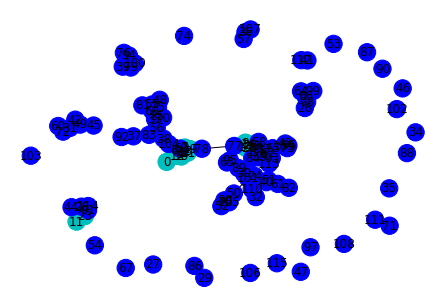

In [19]:
vs.draw_connectivity_graph()
sampleset = [v[0] for v in vs.samples_outside_regions.values()]
plot_points(np.array(vs.seed_points), prefix = 'guard', color = Rgba(0.06, 0.0, 0.8, 1))
plot_points(np.array(sampleset), size=0.01, prefix = 'sampleset', color = Rgba(0.06, 0.8, 0.8, 1))

# Connectivity Phase

In [20]:
vs.connectivity_phase() 

[01:29:44] [VPRMSeeding] Num connected Components Vis: 6
[01:30:22] [VPRMSeeding] New region added [ 1.1919349  -2.00040104 -0.46439786 -0.71680219  0.45410612  0.69760319
  0.12497188]
[01:30:22] [VPRMSeeding] Sample set size 492 num keys to del  2
[01:30:23] [VPRMSeeding] Num connected Components Vis: 5
[01:31:03] [VPRMSeeding] New region added [ 1.46821728 -1.72214101  0.02556264 -0.26787573  1.12944453  0.29856002
 -0.28047243]
[01:31:03] [VPRMSeeding] Sample set size 489 num keys to del  3
[01:31:04] [VPRMSeeding] Num connected Components Vis: 4
[01:31:41] [VPRMSeeding] New region added [ 1.04227987  0.71035848 -2.5035436  -1.88081817  0.03021535  1.71326287
  2.71840218]
[01:31:41] [VPRMSeeding] Sample set size 488 num keys to del  1
[01:31:42] [VPRMSeeding] Num connected Components Vis: 4
[01:32:37] [VPRMSeeding] New region added [ 1.73124841 -1.51898603 -1.38717024  0.03847282  1.94423769  0.98457611
  2.30531462]
[01:32:37] [VPRMSeeding] Sample set size 487 num keys to del  1


True

In [17]:
vs.draw_connectivity_graph()

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

<Figure size 432x288 with 0 Axes>

In [22]:
# samps_cnt = 10000
# samp_in_regions = 0
# for _ in range(samps_cnt):
#     q_samp = vs.sample_node_pos(outside_regions=False)
#     if vs.point_in_regions(q_samp):
#         samp_in_regions += 1
# print(samp_in_regions/samps_cnt)

In [16]:
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(vs.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))
path_length_ratio = []
dspp.verbose = True
for i,pt1 in enumerate(poi[:11]):
    for pt2 in poi[i+1:12]:
        wp, dist = dspp.solve(pt1, pt2, refine_path = True)
        dist_lower = np.linalg.norm( pt1 - pt2)
        path_length_ratio.append(dist/dist_lower)
print(np.mean(path_length_ratio))

[DijkstraSPP] Pre-Building adjacency matrix  0 / 714
[DijkstraSPP] Pre-Building adjacency matrix  10 / 714
[DijkstraSPP] Pre-Building adjacency matrix  20 / 714
[DijkstraSPP] Pre-Building adjacency matrix  30 / 714
[DijkstraSPP] Pre-Building adjacency matrix  40 / 714
[DijkstraSPP] Pre-Building adjacency matrix  50 / 714
[DijkstraSPP] Pre-Building adjacency matrix  60 / 714
[DijkstraSPP] Pre-Building adjacency matrix  70 / 714
[DijkstraSPP] Pre-Building adjacency matrix  80 / 714
[DijkstraSPP] Pre-Building adjacency matrix  90 / 714
[DijkstraSPP] Pre-Building adjacency matrix  100 / 714
[DijkstraSPP] Pre-Building adjacency matrix  110 / 714
[DijkstraSPP] Pre-Building adjacency matrix  120 / 714
[DijkstraSPP] Pre-Building adjacency matrix  130 / 714
[DijkstraSPP] Pre-Building adjacency matrix  140 / 714
[DijkstraSPP] Pre-Building adjacency matrix  150 / 714
[DijkstraSPP] Pre-Building adjacency matrix  160 / 714
[DijkstraSPP] Pre-Building adjacency matrix  170 / 714
[DijkstraSPP] Pre-Bui

In [25]:
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(rs.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))
path_length_ratio = []
dspp.verbose = True
for i,pt1 in enumerate(poi[:11]):
    for pt2 in poi[i+1:12]:
        wp, dist = dspp.solve(pt1, pt2, refine_path = True)
        dist_lower = np.linalg.norm( pt1 - pt2)
        path_length_ratio.append(dist/dist_lower)
print(np.mean(path_length_ratio))

[DijkstraSPP] Pre-Building adjacency matrix  0 / 695
[DijkstraSPP] Pre-Building adjacency matrix  10 / 695
[DijkstraSPP] Pre-Building adjacency matrix  20 / 695
[DijkstraSPP] Pre-Building adjacency matrix  30 / 695
[DijkstraSPP] Pre-Building adjacency matrix  40 / 695
[DijkstraSPP] Pre-Building adjacency matrix  50 / 695
[DijkstraSPP] Pre-Building adjacency matrix  60 / 695
[DijkstraSPP] Pre-Building adjacency matrix  70 / 695
[DijkstraSPP] Pre-Building adjacency matrix  80 / 695
[DijkstraSPP] Pre-Building adjacency matrix  90 / 695
[DijkstraSPP] Pre-Building adjacency matrix  100 / 695
[DijkstraSPP] Pre-Building adjacency matrix  110 / 695
[DijkstraSPP] Pre-Building adjacency matrix  120 / 695
[DijkstraSPP] Pre-Building adjacency matrix  130 / 695
[DijkstraSPP] Pre-Building adjacency matrix  140 / 695
[DijkstraSPP] Pre-Building adjacency matrix  150 / 695
[DijkstraSPP] Pre-Building adjacency matrix  160 / 695
[DijkstraSPP] Pre-Building adjacency matrix  170 / 695
[DijkstraSPP] Pre-Bui

[DijkstraSPP] optimized distance/ start-distance = 6.80 / 8.54 = 0.80
1.5624483954250068


In [28]:
a = dspp.base_ad_mat.row
b = dspp.base_ad_mat.col
edges = []# = [[a1,b1] for a1, b1 in zip(a,b)]
for n in dspp.node_intersections:
    regs = n.regions
    regs_idx = [rs.regions.index(reg) for reg in regs]
    edges.append(regs_idx)

In [29]:
from scipy.sparse import coo_matrix
ad_mat = coo_matrix((714, 714), np.float32)

In [30]:
rows = [e[0] for e in edges]
cols = [e[1] for e in edges]
data = [1.0 for e in edges]
ad_mat = coo_matrix((data, (rows,cols)), shape = (695, 695))

In [34]:
len(np.where(connected_components(ad_mat)[1] ==0)[0])

688

In [33]:
connected_components(ad_mat)

(8,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.csgraph import connected_components

#connected_components(dspp.base_ad_mat)

In [40]:
dspp.base_ad_mat.shape

(4477, 4477)

In [24]:
data = {'admat': dspp.base_ad_mat,
        'node_intersections': dspp.node_intersections}

with open("dspp_vprmregions.pickle", "wb") as f:
    pickle.dump(data,f)

In [31]:
np.mean(path_lengths)

4.4544711577995235

In [34]:
t1 = time.time()
for idx in range(1000):
    vs.regions[0].ChebyshevCenter()
t2 = time.time()
print((t2 - t1) / 1000)

0.006727414846420288


In [35]:
t1 = time.time()
for idx in range(1000):
    vs.regions[0].MaximumVolumeInscribedEllipsoid().center()
t2 = time.time()
print((t2 - t1) / 1000)

0.08371805047988892


In [15]:
from pydrake.all import VPolytope
cols = n_colors_random(1)
colors = []
for col in cols:
    colors.append(Rgba(*[ci/255 for ci in col], 0.4))
for idx_reg, (color,r) in enumerate(zip(colors,vs.regions[-1:])):
    verts = VPolytope(r).vertices()
    idx_plot = np.random.choice(verts.shape[1], 120)
    vert_plot = verts[:, idx_plot]
    for idx_vert, v in enumerate(vert_plot.T):
        q = Ratfk.ComputeQValue(v, np.zeros(7))
        plot_endeff_pose(q, 'r_'+str(idx_reg)+'/'+str(idx_vert), color)

In [26]:
len(vs.regions[vs.guard_regions[-1]+1:])


6

In [14]:
from pydrake.all import CspaceFreeRegion
import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics

In [15]:
region_to_certify = vs.regions[-1]
seed_point_cert = vs.seed_points[-1]

In [16]:
cfree_cert = CspaceFreeRegion(diagram, 
                         plant, 
                         scene_graph, 
                         rational_forward_kinematics.SeparatingPlaneOrder.kAffine, 
                         rational_forward_kinematics.CspaceRegionType.kGenericPolytope)

filtered_collision_pairs = set()
solver_options = mp.SolverOptions()
# make the solver verbose
solver_options.SetOption(mp.CommonSolverOption.kPrintToConsole, 1)

In [17]:
sg_context = scene_graph.GetMyContextFromRoot(context)
inspector = scene_graph.model_inspector()

pairs = scene_graph.get_query_output_port().Eval(sg_context).inspector().GetCollisionCandidates()

gids = [gid for gid in inspector.GetGeometryIds(GeometrySet(inspector.GetAllGeometryIds()), Role.kProximity)]
get_name_of_gid = lambda gid : inspector.GetName(gid)
gids.sort(key=get_name_of_gid)
static_geometry_set =  GeometrySet([gid for gid in gids if "shelves" in get_name_of_gid(gid)] + [gid for gid in gids if "ground" in get_name_of_gid(gid)] + [gid for gid in gids if "lid" in get_name_of_gid(gid)])
scene_graph.collision_filter_manager()\
            .Apply(CollisionFilterDeclaration().ExcludeWithin(static_geometry_set))
# for i, gid1 in enumerate(gids):
#     for gid2 in gids[i+1:]:
        
# id_pairs_of_interest = [(gid1, gid2) for i, gid1 in enumerate(gids) for gid2 in gids[i+1:]]
# #print(id_pairs_of_interest)
# len(id_pairs_of_interest)
# for i in static_ids:
#     print(get_name_of_gid(i))
pairs_new = scene_graph.get_query_output_port().Eval(sg_context).inspector().GetCollisionCandidates()

In [19]:
binary_search_options = rational_forward_kinematics.BinarySearchOption()
binary_search_options.epsilon_max = 1e-3 # it is very unlikely that we can find a uniform expansion of the current region
binary_search_options.max_iters = 1
# speed up the bisection search by taking non-uniform steps when possible
binary_search_options.search_d = True
# find the smallest e such that At <= b + e1 still contains our seed point.
binary_search_options.epsilon_min = 0#rational_forward_kinematics.FindEpsilonLower(region_to_certify.A(), region_to_certify.b(),
#                                                                                  limits_t[0], limits_t[1],
#                                                                                  seed_point_cert)
binary_search_options.num_threads = 5

In [20]:
certified_region_contraction_solution = cfree_cert.CspacePolytopeBinarySearch(np.zeros(7),
                                                                 set(),
                                                                 region_to_certify.A(),
                                                                 region_to_certify.b(),
                                                                 binary_search_options, 
                                                                 solver_options,
                                                                 seed_point_cert)
certified_region_contraction = HPolyhedron(certified_region_contraction_solution.C,
                                           certified_region_contraction_solution.d)

SystemExit: Failure at multibody/rational_forward_kinematics/cspace_free_region.cc:1795 in CspacePolytopeBinarySearch(): condition 'binary_search_option.epsilon_min >= FindEpsilonLower(C, d_init, t_lower, t_upper, t_inner_pts, inner_polytope)' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [53]:
len(pairs_new)

302

# Build Configuartion Graph for SPP

In [45]:
dspp = DijkstraSPPsolver(vs.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))

[DijkstraSPP] Pre-Building adjacency matrix  0 / 122
[DijkstraSPP] Pre-Building adjacency matrix  10 / 122
[DijkstraSPP] Pre-Building adjacency matrix  20 / 122
[DijkstraSPP] Pre-Building adjacency matrix  30 / 122
[DijkstraSPP] Pre-Building adjacency matrix  40 / 122
[DijkstraSPP] Pre-Building adjacency matrix  50 / 122
[DijkstraSPP] Pre-Building adjacency matrix  60 / 122
[DijkstraSPP] Pre-Building adjacency matrix  70 / 122
[DijkstraSPP] Pre-Building adjacency matrix  80 / 122
[DijkstraSPP] Pre-Building adjacency matrix  90 / 122
[DijkstraSPP] Pre-Building adjacency matrix  100 / 122
[DijkstraSPP] Pre-Building adjacency matrix  110 / 122
[DijkstraSPP] Pre-Building adjacency matrix  120 / 122


In [1]:
vs.regions

NameError: name 'vs' is not defined

## Helper functions for animations

In [41]:
def densify_waypoints(waypoints_t):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_t[:-1])):
        a = waypoints_t[idx]
        b = waypoints_t[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_t[idx]*tval + waypoints_t[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        set_joint_angles(qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

# Prebuild Adjacency Matrix 

In [42]:
# base_ad_mat, node_intersections = build_base_adjacency_matrix(vs.regions)
# point_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))

In [128]:
import time
start = poi[np.random.choice(12,1)[0]]
meshcat1.Delete("/iris/points/traj/") 
terminate = False
dspp.verbose = True
for _ in range(90):
    #vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(12,1)[0]]
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path = False)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion)
    #print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for ta in dense_waypoints:
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            showres(qa)
            if col_func_handle(qa):
                terminate = True
                color = Rgba(1,0,0.1,0.4)
   
                tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
                tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

                meshcat1.SetObject(f"/iris/points/traj/coll",
                               Sphere(0.1),
                               color)

                meshcat1.SetTransform(f"/iris/points/traj/coll",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
                
                
                #break
            time.sleep(0.012)
        #if terminate:
        #    break
        start = nxt
        #time.sleep(0.1)
        meshcat1.Delete("/iris/points/traj/")     
    else:
        nxt = vs.sample_in_regions()

KeyboardInterrupt: 

In [38]:
samps_cnt = 10000
samp_in_regions = 0
for _ in range(samps_cnt):
    q_samp = rs.sample_node_pos()
    if rs.point_in_regions(q_samp):
        samp_in_regions += 1
coverage = samp_in_regions/samps_cnt

In [39]:
coverage

0.2638

# Evaluation

In [60]:
from datetime import date, datetime
import time
from visprm import RandSeeding
now = datetime.now()
timestamp = now.strftime("%y_%m_%d_%H_%M_%S")
filename = timestamp+'_eval.log'
with open(filename, 'w+') as file:  
    for i_seed in range(8,20):
        t1 = time.time()
        np.random.seed(i_seed)
        vs2 = VPRMSeeding(poi,
                     alpha = 0.1,
                     limits = limits_q,
                     collision_handle = col_func_handle,
                     is_in_line_of_sight = is_LOS, 
                     iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                     iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                     point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                     )
        vs2.set_guard_regions()
        vs2.guard_phase()
        vs2.refine_guards()
        success = vs2.connectivity_phase()
        t2 = time.time()
        number_guards = len(vs2.guard_regions)
        number_regions = len(vs2.regions)
        number_samples = len(vs2.samples_outside_regions)
        dspp = dijkstraspp.DijkstraSPPsolver(vs2.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))
        path_length_ratio = []
        dspp.verbose = False
        for i,pt1 in enumerate(poi[:11]):
            for pt2 in poi[i+1:12]:
                wp, dist = dspp.solve(pt1, pt2, refine_path = True)
                dist_lower = np.linalg.norm( pt1 - pt2)
                path_length_ratio.append(dist/dist_lower)
        print(np.mean(path_length_ratio))
        #determine coverage
        samps_cnt = 10000
        samp_in_regions = 0
        for _ in range(samps_cnt):
            q_samp = vs2.sample_node_pos(outside_regions=False)
            if vs2.point_in_regions(q_samp):
                samp_in_regions += 1
        coverage = samp_in_regions/samps_cnt
        run_string = [(f"""{'--visprm'},\n"""),
                      (f"""{'seed:'}{i_seed},\n"""),
                     (f"""{'success: '+str(success)},\n"""),
                     (f"""{'nr: '}{number_regions},\n"""),
                     (f"""{'ng: '}{number_guards},\n"""),
                     (f"""{'ns: '}{number_samples},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'pathlen: '}{np.mean(path_length_ratio):.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                     ]
        file.writelines(run_string)
        print('switch to random seeding')
        t1 = time.time()
        np.random.seed(i_seed)
        rs2 = RandSeeding(poi,
              alpha = 0.1,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
        rs2.set_init_regions()
        success = rs2.sample_regions_phase()
        t2 = time.time()
        number_regions = len(rs2.regions)
        #number_samples = len(rs.samples_outside_regions)
        dspp = DijkstraSPPsolver(rs2.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))
        path_length_ratio = []
        dspp.verbose = False
        for i,pt1 in enumerate(poi[:11]):
            for pt2 in poi[i+1:12]:
                wp, dist = dspp.solve(pt1, pt2, refine_path = True)
                dist_lower = np.linalg.norm( pt1 - pt2)
                path_length_ratio.append(dist/dist_lower)
        #print(np.mean(path_length_ratio))
        #determine coverage
        samps_cnt = 10000
        samp_in_regions = 0
        for _ in range(samps_cnt):
            q_samp = rs2.sample_node_pos()
            if rs2.point_in_regions(q_samp):
                samp_in_regions += 1
        coverage = samp_in_regions/samps_cnt
        run_string = [(f"""{'--rand'},\n"""),
                      (f"""{'seed: '}{i_seed},\n"""),
                     (f"""{'success: '+str(success)},\n"""),
                     (f"""{'nr: '}{number_regions},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'pathlen: '}{np.mean(path_length_ratio):.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                      
                     ]
        file.writelines(run_string)

[16:45:37] [VPRMSeeding] Expecting points of interest in q
[16:45:37] [VPRMSeeding] GuardInsertion attempts M: 44
[16:45:37] [VPRMSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 
[16:48:20] [VPRMSeeding] New guard placed N =  24 it =  0
[16:48:22] [VPRMSeeding] Sample set size 0
[16:48:22] [VPRMSeeding] New guard placed N =  25 it =  1
[16:48:23] [VPRMSeeding] Sample set size 0
[16:48:23] [VPRMSeeding] New guard placed N =  26 it =  1
[16:48:28] [VPRMSeeding] Sample set size 0
[16:48:28] [VPRMSeeding] New guard placed N =  27 it =  4
[16:48:33] [VPRMSeeding] Sample set size 3
[16:48:33] [VPRMSeeding] New guard placed N =  28 it =  1
[16:49:00] [VPRMSeeding] Sample set size 3
[16:49:00] [VPRMSeeding] New guard placed N =  29 it =  1
[16:49:05] [VPRMSeeding] Sample set size 3
[16:49:05] [VPRMSeeding] New guard placed N =  30 it =  1
[16:49:12] [VPRMSeeding] Sample set size 3
[16:49:12] [VPRMSeeding] New guard placed N =  31 it =  2
[16:49:33] [VPRMSeeding] Sampl

[17:02:35] [VPRMSeeding] Num connected Components Vis: 3
[17:02:50] [VPRMSeeding] New region added [-1.52071349 -1.1737263   0.46436616  0.83557042  1.68273318  0.55546677
  2.40476187]
[17:02:50] [VPRMSeeding] Sample set size 259 num keys to del  1
[17:02:50] [VPRMSeeding] Num connected Components Vis: 3
[17:03:24] [VPRMSeeding] New region added [-0.66878959  0.03136411  2.16890224  1.7094609  -1.83464572  1.13182595
  0.35248861]
[17:03:24] [VPRMSeeding] Sample set size 257 num keys to del  2
[17:03:25] [VPRMSeeding] Num connected Components Vis: 3
[17:03:49] [VPRMSeeding] New region added [ 1.10893219 -1.72608083 -2.10715087 -0.42423306 -2.30611518 -0.6616647
 -0.43637357]
[17:03:49] [VPRMSeeding] Sample set size 256 num keys to del  1
[17:03:50] [VPRMSeeding] Num connected Components Vis: 3
[17:04:34] [VPRMSeeding] New region added [ 1.56555257 -1.02512401 -0.51047667  0.662672    0.52267701 -1.25926478
  1.17349781]
[17:04:34] [VPRMSeeding] Sample set size 255 num keys to del  1
[

[17:36:58] [RandSeeding] New Region placed N =  82 , it =  0
[17:37:17] [RandSeeding] New Region placed N =  83 , it =  0
[17:37:57] [RandSeeding] New Region placed N =  84 , it =  0
[17:38:15] [RandSeeding] New Region placed N =  85 , it =  0
[17:38:37] [RandSeeding] New Region placed N =  86 , it =  0
[17:39:19] [RandSeeding] New Region placed N =  87 , it =  0
[17:39:32] [RandSeeding] New Region placed N =  88 , it =  0
[17:40:10] [RandSeeding] New Region placed N =  89 , it =  0
[17:40:20] [RandSeeding] New Region placed N =  90 , it =  0
[17:40:36] [RandSeeding] New Region placed N =  91 , it =  0
[17:40:50] [RandSeeding] New Region placed N =  92 , it =  0
[17:41:14] [RandSeeding] New Region placed N =  93 , it =  0
[17:41:36] [RandSeeding] New Region placed N =  94 , it =  0
[17:41:47] [RandSeeding] New Region placed N =  95 , it =  1
[17:42:20] [RandSeeding] New Region placed N =  96 , it =  0
[17:42:42] [RandSeeding] New Region placed N =  97 , it =  0
[17:43:11] [RandSeeding]

[18:44:37] [RandSeeding] New Region placed N =  213 , it =  0
[18:45:28] [RandSeeding] New Region placed N =  214 , it =  0
[18:45:50] [RandSeeding] Mosek failed, deleting point
[18:45:50] [RandSeeding] New Region placed N =  214 , it =  0
[18:46:50] [RandSeeding] New Region placed N =  215 , it =  0
[18:47:14] [RandSeeding] New Region placed N =  216 , it =  0
[18:47:53] [RandSeeding] New Region placed N =  217 , it =  0
[18:48:21] [RandSeeding] New Region placed N =  218 , it =  0
[18:48:49] [RandSeeding] New Region placed N =  219 , it =  0
[18:49:23] [RandSeeding] New Region placed N =  220 , it =  1
[18:50:08] [RandSeeding] New Region placed N =  221 , it =  0
[18:50:37] [RandSeeding] New Region placed N =  222 , it =  0
[18:51:37] [RandSeeding] New Region placed N =  223 , it =  1
[18:52:02] [RandSeeding] New Region placed N =  224 , it =  0
[18:52:33] [RandSeeding] Mosek failed, deleting point
[18:52:33] [RandSeeding] New Region placed N =  224 , it =  0
[18:53:03] [RandSeeding]

KeyboardInterrupt: 

In [59]:
for i in range(8, 20):
    print(i)

8
9
10
11
12
13
14
15
16
17
18
19


In [45]:
rs.regions

In [46]:
reg = rs.regions[0]

In [47]:
reg

In [117]:
from pydrake.all import MathematicalProgram, le, GetProgramType, Solve 
def getAABB(poly):
    prog = MathematicalProgram()
    r = rs.regions[0]
    dim = r.ambient_dimension()

    cost = 0
    intermediates_p = []
    intermediates_n = []
    #dact = 6
    for d in range(dim):
    #     fp = np.zeros(dim)
    #     fn = np.zeros(dim)
    #     fp[d] = 1
    #     fn[d] = -1
        tp = prog.NewContinuousVariables(dim, 'xp'+str(d))
        tn = prog.NewContinuousVariables(dim, 'xn'+str(d))
        intermediates_p.append(tp)
        intermediates_n.append(tn)
        prog.AddConstraint(le(r.A()@tp, r.b())) 
        prog.AddConstraint(le(r.A()@tn, r.b())) 
        cost-= tp[d]
        cost+= tn[d]

    prog.AddCost(cost)    
    sol = Solve(prog)
    upperbound = []
    lowerbound = []
    tp_sol = []
    tn_sol = []
    if sol.is_success():
        for d, i in enumerate(intermediates_p):
            upperbound.append(sol.GetSolution(i)[d])
            tp_sol.append(sol.GetSolution(i))
        for d, i in enumerate(intermediates_n):
            lowerbound.append(sol.GetSolution(i)[d])
            tn_sol.append(sol.GetSolution(i))
    AABB = HPolyhedron.MakeBox(np.array(lowerbound), np.array(upperbound))

0.002257131520785816
0.0022571429376401055


In [116]:
for s in tn_sol:
    print(r.PointInSet(s))
for s in tp_sol:
    print(r.PointInSet(s))
    
for tn,tp in zip(tn_sol, tp_sol):
    print((tp-tn)[dact])

True
True
9.981441111033984


In [69]:
cost

<Expression "(xp0(0) - xn0(0) + xp1(1) - xn1(1) + xp2(2) - xn2(2) + xp3(3) - xn3(3) + xp4(4) - xn4(4) + xp5(5) - xn5(5) + xp6(6) - xn6(6))">

In [66]:
lowerbound

[0.8489878249968297,
 0.6443502073583969,
 0.14844376269175807,
 -1.4233386848430003,
 -1.6643862957987139,
 1.0139237702215127,
 -5.027384527824985]

In [67]:
upperbound

[0.9664612281324452,
 0.5014177600361418,
 0.14844376269175807,
 -1.4233386848430003,
 -1.6643862957987139,
 1.010273364427735,
 -5.027384527824985]

In [30]:
f = open("22_12_13_21_02_08_eval.log", "r")
lines = f.readlines()
vprmseed = {}
vprmseed['succ'] = []
vprmseed['nr'] = []
vprmseed['ng'] = []
vprmseed['ns'] = []
vprmseed['seed'] = []
vprmseed['coverage'] = []
vprmseed['pathlenratio'] = []
vprmseed['runtime'] = []

randseed = {}
randseed['succ'] = []
randseed['nr'] = []
randseed['seed'] = []
randseed['coverage'] = []
randseed['pathlenratio'] = []
randseed['runtime'] = []

joint_keys = ['succ', 'nr', 'runtime', 'coverage', 'pathlenratio']
idx = 0
while idx< len(lines):
   
    if '--visprm' in lines[idx]:
        #print(lines[idx:idx+9])
        line_run = lines[idx:idx+9]
        #print(line_run[1][5:-2])
        vprmseed['seed'].append(int(line_run[1][5:-2]))
        vprmseed['succ'].append(True if line_run[2][9:-2] =='True' else False)
        vprmseed['nr'].append(int(line_run[3][3:-2]))  
        vprmseed['ng'].append(int(line_run[4][3:-2]))  
        vprmseed['ns'].append(int(line_run[5][3:-2]))  
        vprmseed['coverage'].append(float(line_run[6][9:-2])) 
        vprmseed['pathlenratio'].append(float(line_run[7][8:-2]))
        vprmseed['runtime'].append(float(line_run[8][8:-2]))  
        idx+=9
    elif '--rand' in lines[idx]:
        #print(lines[idx:idx+7])
        line_run = lines[idx:idx+7]
        randseed['seed'].append(int(line_run[1][5:-2]))
        randseed['succ'].append(True if line_run[2][9:-2] =='True' else False)
        randseed['nr'].append(int(line_run[3][3:-2]))
        randseed['coverage'].append(float(line_run[4][9:-2]))
        randseed['pathlenratio'].append(float(line_run[5][8:-2]))
        randseed['runtime'].append(float(line_run[6][8:-2]))
        idx +=7
    
    #idx+=1
f.close()

Text(0.5, 0.98, 'Eval 7Dof 24 PoI, N =9')

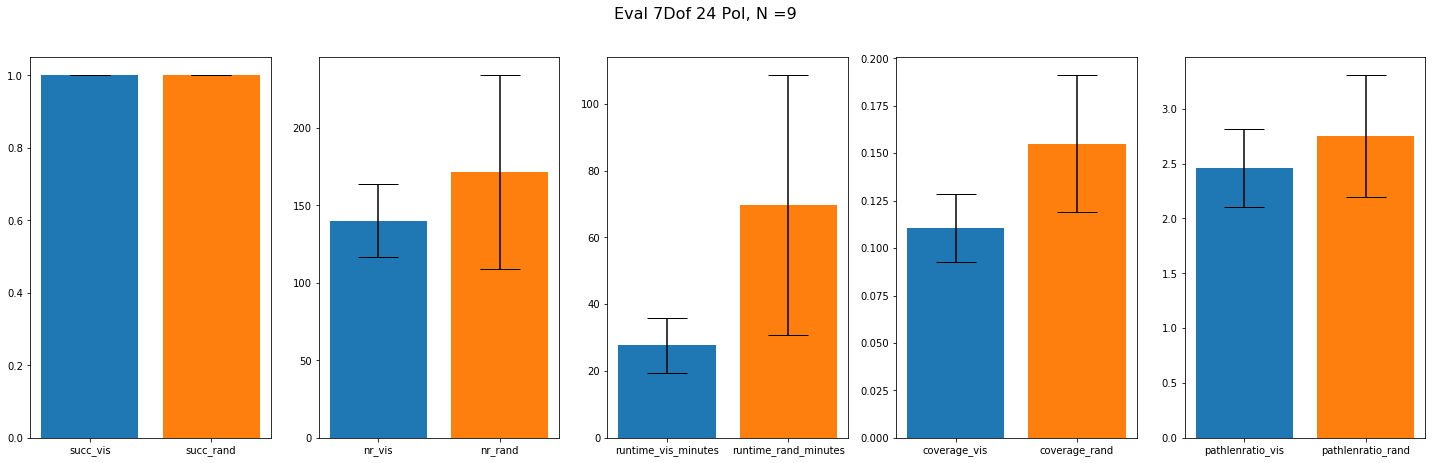

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = len(joint_keys), figsize = (25, 7))
for ax, key in zip(axs, joint_keys):
    nfields = 2
    xpos = np.arange(nfields)
    labels = [key+'_vis', key+'_rand']
    data_mean = [np.mean(np.array(vprmseed[key])*1.0), np.mean(np.array(randseed[key])*1.0)]
    data_std = [np.std(np.array(vprmseed[key])*1.0), np.std(np.array(randseed[key])*1.0)]
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels)
    if key == 'runtime':
        data_mean = [np.mean(np.array(vprmseed[key])*1.0)/60.0, np.mean(np.array(randseed[key])*1.0)/60.0]
        data_std = [np.std(np.array(vprmseed[key])*1.0)/60.0, np.std(np.array(randseed[key])*1.0)/60.0,]
        ax.set_xticks(xpos)
        ax.set_xticklabels(['runtime_vis_minutes', 'runtime_rand_minutes'])
    ax.bar(xpos, data_mean, yerr = data_std,color=['#1f77b4','#ff7f0e'], ecolor='black', capsize=20)
    
fig.suptitle('Eval 7Dof 24 PoI, N ='+str(len(vprmseed['seed'])), fontsize=16)

In [145]:
f = open("22_11_29_21_48_44eval_log.log", "r")
lines = f.readlines()
vprmseed = {}
vprmseed['succ'] = []
vprmseed['nr'] = []
vprmseed['ng'] = []
vprmseed['ns'] = []
vprmseed['seed'] = []
vprmseed['coverage'] = []
vprmseed['runtime'] = []

randseed = {}
randseed['succ'] = []
randseed['nr'] = []
randseed['seed'] = []
randseed['coverage'] = []
randseed['runtime'] = []

joint_keys = ['succ', 'nr', 'runtime', 'coverage']
idx = 0
while idx< len(lines):
    if '--visprm' in lines[idx]:
        #print(lines[idx:idx+7])
        line_run = lines[idx:idx+7]
        vprmseed['seed'].append(int(line_run[0][14:-2]))
        vprmseed['succ'].append(True if line_run[1][9:-2] =='True' else False)
        vprmseed['nr'].append(int(line_run[2][3:-2]))  
        vprmseed['ng'].append(int(line_run[3][3:-2]))  
        vprmseed['ns'].append(int(line_run[4][3:-2]))  
        vprmseed['coverage'].append(float(line_run[5][9:-2]))  
        vprmseed['runtime'].append(float(line_run[6][8:-2]))  
        idx+=7
    elif '--rand seed' in lines[idx]:
        print(lines[idx:idx+5])
        line_run = lines[idx:idx+7]
        randseed['seed'].append(int(line_run[0][12:-2]))
        randseed['succ'].append(True if line_run[1][9:-2] =='True' else False)
        randseed['nr'].append(int(line_run[2][3:-2]))
        randseed['coverage'].append(float(line_run[3][9:-2]))
        randseed['runtime'].append(float(line_run[4][8:-2]))
        idx +=5
f.close()

['--rand seed:0,\n', 'success: True,\n', 'nr: 69,\n', 'coverage: 0.1687,\n', 'runtime: 819.3097,\n']
['--rand seed:1,\n', 'success: True,\n', 'nr: 39,\n', 'coverage: 0.1284,\n', 'runtime: 407.6527,\n']
['--rand seed:2,\n', 'success: True,\n', 'nr: 64,\n', 'coverage: 0.1712,\n', 'runtime: 855.7786,\n']
['--rand seed:3,\n', 'success: True,\n', 'nr: 47,\n', 'coverage: 0.1131,\n', 'runtime: 488.1396,\n']
['--rand seed:4,\n', 'success: True,\n', 'nr: 52,\n', 'coverage: 0.1476,\n', 'runtime: 554.5485,\n']
['--rand seed:5,\n', 'success: True,\n', 'nr: 82,\n', 'coverage: 0.1614,\n', 'runtime: 935.1843,\n']
['--rand seed:6,\n', 'success: True,\n', 'nr: 57,\n', 'coverage: 0.1580,\n', 'runtime: 719.9720,\n']
['--rand seed:7,\n', 'success: True,\n', 'nr: 32,\n', 'coverage: 0.0579,\n', 'runtime: 224.4085,\n']
['--rand seed:8,\n', 'success: True,\n', 'nr: 19,\n', 'coverage: 0.0503,\n', 'runtime: 141.7112,\n']
['--rand seed:9,\n', 'success: True,\n', 'nr: 56,\n', 'coverage: 0.1065,\n', 'runtime: 520.

Text(0.5, 0.98, 'Eval 7Dof 12 PoI, N =20')

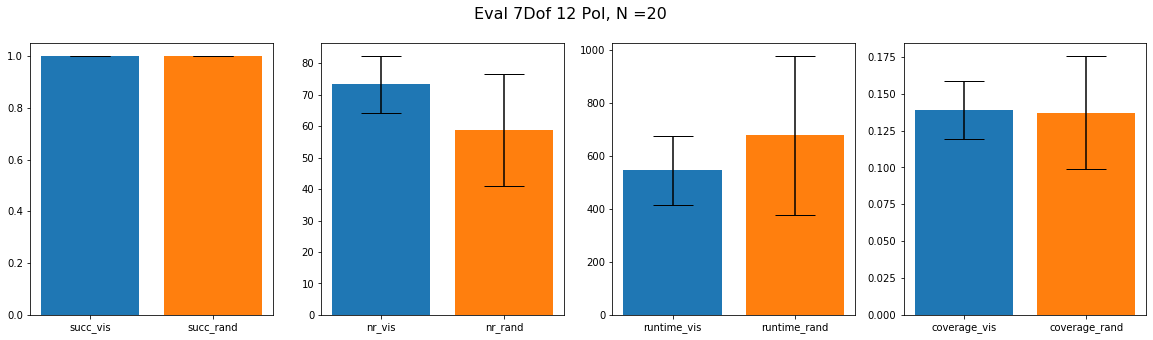

In [162]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = len(joint_keys), figsize = (20, 5))
for ax, key in zip(axs, joint_keys):
    nfields = 2
    xpos = np.arange(nfields)
    labels = [key+'_vis', key+'_rand']
    data_mean = [np.mean(np.array(vprmseed[key])*1.0), np.mean(np.array(randseed[key])*1.0)]
    data_std = [np.std(np.array(vprmseed[key])*1.0), np.std(np.array(randseed[key])*1.0)]
    ax.bar(xpos, data_mean, yerr = data_std,color=['#1f77b4','#ff7f0e'], ecolor='black', capsize=20)
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels)
fig.suptitle('Eval 7Dof 12 PoI, N ='+str(len(vprmseed['seed'])), fontsize=16)

# Random Seeding

In [90]:
rs = RandSeeding(poi,
              alpha = 0.1,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
rs.set_init_regions()

[02:23:47] [RandSeeding] Expecting points of interest in q
[02:23:47] [RandSeeding] GuardInsertion attempts M: 44
[02:23:47] [RandSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


In [ ]:
rs.sample_regions_phase()

In [ ]:
rs.draw_connectivity_graph()

# RRT

In [ ]:
from rrt import RRT
RRT = RRT(start = poi[0],
          goal = poi[-1],
          limits = limits_q,
          col_func_handle=col_func_handle,
          max_extend_length=0.1,
          extend_steps=0.002,
          init_goal_sample_rate=0.1,
          goal_sample_rate_scaler=0.9,
          verbose = True, 
          plotcallback = None,
          sample_collision_free= False)

success, path = RRT.run(100000)